## **1. Dataset**

The goal of this project is to build an NLP (Natural Language Processing) system that can automatically classify mobile text messages as either ham (legitimate) or spam. For this, the [SMS Spam Collection dataset](https://doi.org/10.24432/C5CC84.) is used. It contains 5,572 real-world SMS messages collected from mobile platforms, each manually labelled as _ham_ or _spam_. Since SMS spam is a common and persistent issue that affects user privacy and can lead to scams, building an automated detection system is both useful and necessary.

The dataset is well-suited for binary classification, and the text-based nature of the problem makes it ideal for NLP and comparing classification models. Before applying any machine learning models, the data is loaded, inspected for structure, and explored for characteristics such as class distribution and message length, which may have different patterns for _ham_ and _spam_. Basic preprocessing is applied, including converting text to lowercase, removing punctuation, and normalising spacing. This helps prepare the messages for vectorisation and reduces noise in the representation (e.g. _dont_ is the same as _don't_).

Initial exploration also includes analysing common words found in both spam and ham messages to better understand the dataset. This gives insight into the patterns each class contains, such as promotional keywords in spam and conversational language in ham.

In [267]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load the SMS Spam dataset
df = pd.read_csv('data/SMSSpamCollection',
                 sep='\t', 
                 header=None, 
                 names=['label', 'message'],
                 encoding='utf-8')

print("Dataset shape:", df.shape) # initial inspection of the dataset showing the first 5 rows
df.head()

Dataset shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [268]:
print(df.info())

# check class distribution
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


In [269]:
# balance the 'ham' to be the same number as 'spam' (it removes the chance of biasing the model classification performance)
from sklearn.utils import resample

ham = df[df['label'] == 'ham']
spam = df[df['label'] == 'spam']

# chose upsampling to have a large dataset
spam_samples = resample(spam, replace=True, n_samples=len(ham), random_state=42)

df = pd.concat([ham, spam_samples]).reset_index(drop=True)

print(df['label'].value_counts())

label
ham     4825
spam    4825
Name: count, dtype: int64


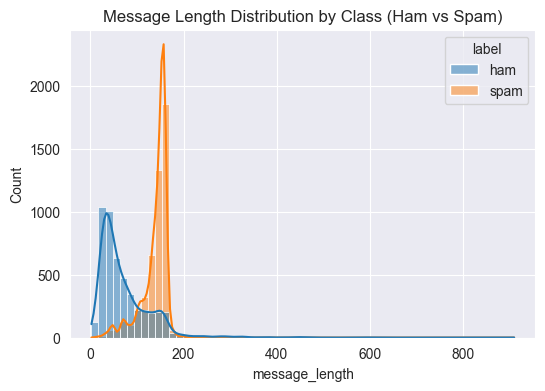

In [270]:
# class distribution of message length
df['message_length'] = df['message'].str.len()

plt.figure(figsize=(6,4))
sns.histplot(data=df, x='message_length', hue='label', bins=60, kde=True)
plt.title('Message Length Distribution by Class (Ham vs Spam)')
plt.show()

# this density plot highlights the key difference: spam messages (orange) are typically much longer than ham messages (blue), which are concentrated at shorter lengths.


In [271]:
# lowercase text, remove punctuation and spaces
import string

df['message_clean'] = df['message'].str.lower()
df['message_clean'] = df['message_clean'].str.replace(f"[{string.punctuation}]", "", regex=True)
df['message_clean'] = df['message_clean'].str.strip()
df['message_clean'] = df['message_clean'].str.replace('\s+', ' ', regex=True)

In [272]:
# vectorisation of the message
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
X_cv = cv.fit_transform(df['message_clean'])

word_counts = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())
df_counts = pd.concat([df['label'], word_counts], axis=1)

# top spam and ham words
spam_words = df_counts[df_counts['label']=="spam"].drop(columns=['label']).sum().sort_values(ascending=False).head(10)
ham_words = df_counts[df_counts['label']=="ham"].drop(columns=['label']).sum().sort_values(ascending=False).head(10)

print('Top Spam Words:\n', spam_words)
print('Top Ham Words:\n', ham_words)

# top 10 most frequent words (excluding stop words) in the dataset, 'spam' words include promotional and urgent terms (e.g., 'free', 'claim', 'prize'), while ham words are characteristic of casual conversation (e.g., 'im', 'just', 'ok', 'dont').


Top Spam Words:
 free      1417
ur         984
txt        978
text       785
stop       782
claim      754
mobile     718
reply      692
prize      572
nokia      464
dtype: int64
Top Ham Words:
 im      451
just    290
ltgt    276
ok      273
dont    263
ur      246
ill     238
know    232
got     232
like    231
dtype: int64


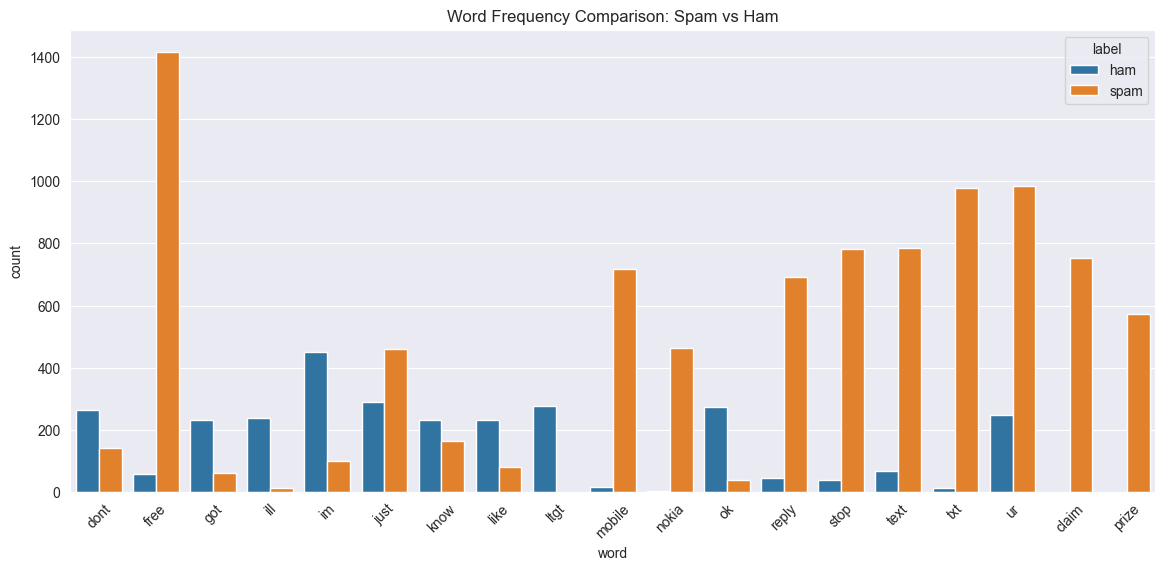

In [273]:
top_words = list(spam_words.index[:20]) + list(ham_words.index[:20])
top_words = list(set(top_words))  # remove duplicates

# keep label and top words for plot
freq_df = df_counts[['label'] + top_words]
freq_long = freq_df.melt(
    id_vars='label',
    var_name='word',
    value_name='count'
)
# keep only non-zero occurrences
freq_long = freq_long[freq_long['count'] > 0]

freq_summary = (
    freq_long
    .groupby(['label', 'word'])['count']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.barplot(data=freq_summary, x='word', y='count', hue='label')
plt.title('Word Frequency Comparison: Spam vs Ham')
plt.xticks(rotation=45)
plt.show()


# comparison showing words like 'won' and 'prize' are key discriminators for spam, while common short words are more frequent in ham.

## **2. Representation Learning**

To train machine learning models on text, SMS messages must be converted into numerical vectors that the algorithm can use to represent the data. One representation-learning methodology, TF-IDF (Term Frequency-Inverse Document Frequency), is used in this case because it is comparable to both classifiers, enabling controlled, consistent, and fair comparisons. Two models will use the same text vectorisation method (TF-IDF), so the performance differences are due to the algorithms, not the data preprocessing.

TF-IDF represents each message by considering how often each word appears in the message and adjusting this value based on how rare the word is across the entire data set (e.g. _the_ would be common in both ham and spam messages). To reduce the impact of very common terms that cannot be used for classification, this weighting method uses selective and informative terms. The existence or non-existence of specific keywords often provides an excellent indication of whether a message is ‘ham’ or ‘spam’. TF-IDF is particularly efficient for short text types and well-suited to more traditional machine learning methods like Logistic Regression and Naïve Bayes.

By consistently using TF-IDF across both pipelines and evaluating with stratified 5-fold cross-validation, the experiment ensures that observed differences in performance reflect the algorithms themselves rather than the quality of the data splits.



In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer

# from english words to vector
df_vector = TfidfVectorizer(stop_words='english')

print(df_vector.fit_transform(df['message_clean'][:1]))

  (np.int32(0), np.int32(8))	0.2773500981126146
  (np.int32(0), np.int32(10))	0.2773500981126146
  (np.int32(0), np.int32(5))	0.2773500981126146
  (np.int32(0), np.int32(1))	0.2773500981126146
  (np.int32(0), np.int32(3))	0.2773500981126146
  (np.int32(0), np.int32(7))	0.2773500981126146
  (np.int32(0), np.int32(12))	0.2773500981126146
  (np.int32(0), np.int32(9))	0.2773500981126146
  (np.int32(0), np.int32(2))	0.2773500981126146
  (np.int32(0), np.int32(4))	0.2773500981126146
  (np.int32(0), np.int32(6))	0.2773500981126146
  (np.int32(0), np.int32(0))	0.2773500981126146
  (np.int32(0), np.int32(11))	0.2773500981126146


## **3. Algorithms**

Two machine learning algorithms: Multinomial Naive Bayes (NB) and Logistic Regression (LR) were implemented using the same TF-IDF vectorisation approach. The dataset was deliberately balanced before training so that both models were exposed to equal numbers of ‘ham’ and ‘spam’ messages. This means any differences in the models’ performance are mainly due to how the two algorithms work rather than issues like class imbalance.

**1. Multinomial Naive Bayes (NB)**  
Multinomial Naive Bayes is a probabilistic model that assumes each feature (in this case, each word) contributes independently to the final prediction. Even though this assumption doesn’t fully reflect how language works, NB has been proven effective for spam detection. SMS spam messages often contain highly recognisable patterns, such as promotional terms or phrases meant to invoke urgency, and NB is good at capturing these because it focuses heavily on word frequencies.
NB calculates the likelihood of each word appearing in the ‘spam’ and ‘ham’ classes, then combines these probabilities to decide which class a new message most likely belongs to. The model handles TF-IDF vectors well. In this case, 5-fold cross-validation was used to make the performance estimate more reliable and less dependent on a single train/test split, which can lead to overfitting.


**2. Logistic Regression (LR)**  
Logistic Regression is a linear classification model that learns a set of feature weights to separate between the two classes (i.e., how relevant a word is to the context of spam or ham messages). Unlike NB, it does not assume feature independence. Instead, LR directly learns how much each TF-IDF feature contributes to predicting ‘spam’ or ‘ham’. Although LR often performs best with dense vector representations, it is still widely used with TF-IDF and typically provides a strong baseline for text classification tasks.
The model in this project was trained with a higher maximum iteration limit (2000) to ensure better training, since the TF-IDF data can be high-dimensional.
Similarly to NB, 5-fold cross-validation was applied to provide a consistent view of how well LR generalises across different portions of the dataset.


**Algorithm Comparison**  
Because both models were trained on a balanced dataset, neither had an inherent advantage during learning. NB tends to perform well when specific keywords strongly characterise spam messages, and its simple probability-based approach often works surprisingly well despite its assumptions.
LR, on the other hand, is slightly more flexible because it learns weights directly rather than relying on conditional probabilities. This allows it to capture more subtle patterns that NB might overlook, especially when spam and ham messages share similar vocabulary. As a result, LR may perform better when distinctions between the classes are less obvious or depend on combinations of words rather than individual terms.


In [275]:
from sklearn.model_selection import StratifiedKFold

# stratified 5-fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [276]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# create pipelines with tf-idf vector and model
pipelines = dict({
    # Naive Bayes
    'Naive Bayes': Pipeline([
        ('tfidf', df_vector),
        ('nb', MultinomialNB())
    ]),
    # Logistic Regression
    'Logistic Regression': Pipeline([
        ('tfidf', df_vector),
        ('lr', LogisticRegression(max_iter=2000, class_weight='balanced'))
    ])
})

cv_results = dict()

# for each model perform 5-fold cross validation and print results
for model, pipeline in pipelines.items():
    cv_results[model] = cross_validate(
        pipeline,
        df['message_clean'],
        df['label'],
        cv=kfold,
        scoring=['precision_macro','recall_macro','f1_macro','accuracy'],
        return_train_score=False
    )

    print(f"{model} stratified 5-fold average results")
    print("Accuracy:", cv_results[model]['test_accuracy'].mean())
    print("Precision:", cv_results[model]['test_precision_macro'].mean())
    print("Recall:", cv_results[model]['test_recall_macro'].mean())
    print("F1:", cv_results[model]['test_f1_macro'].mean())
    print()

Naive Bayes stratified 5-fold average results
Accuracy: 0.9797927461139896
Precision: 0.9798866827654191
Recall: 0.9797927461139896
F1: 0.9797917683278919

Logistic Regression stratified 5-fold average results
Accuracy: 0.9887046632124352
Precision: 0.98872608883113
Recall: 0.9887046632124352
F1: 0.9887045152873091



## **4. Evaluation**
The models were evaluated using a 5-fold cross-validation, ensuring that each fold preserved the balanced class distribution. Using the same metrics (accuracy, precision, recall and F1 score) provides a reliable and fair comparison of the models performance.

The result demonstrates that Logistic Regression (LR) consistently outperforms Multinomial Naive Bayes across all metrics (even though the gap between them averages 1%). LR achieves accuracy of 0.988, compared to NB's 0.979. This indicates that LR identifies both 'ham' and 'spam' messages slightly more accurately, producing fewer false positives and false negatives. Since the dataset is balanced these differences cannot be attributed to class weight or model bias, instead they reflect LR outperforming NB.

NB shows still strong but slightly lower performance then LR, consistent with its reliance on word-independence assumptions. While NB captures major keyword patterns, it cannot exploit more complex relationships between terms that LR can model.

Overall, Logistic Regression is the more accurate and robust classifier for the vectorisation of this SMS dataset.


In [277]:
pd.DataFrame({
    "Model": ["TF-IDF + Naive Bayes", "TF-IDF + Logistic Regression"],
    "Accuracy": [cv_results['Naive Bayes']['test_accuracy'].mean(),
                 cv_results['Logistic Regression']['test_accuracy'].mean()],
    "Precision": [cv_results['Naive Bayes']['test_precision_macro'].mean(),
                  cv_results['Logistic Regression']['test_precision_macro'].mean()],
    "Recall": [cv_results['Naive Bayes']['test_recall_macro'].mean(),
               cv_results['Logistic Regression']['test_recall_macro'].mean()],
    "F1": [cv_results['Naive Bayes']['test_f1_macro'].mean(),
           cv_results['Logistic Regression']['test_f1_macro'].mean()]
})

,Model,Accuracy,Precision,Recall,F1
0,TF-IDF + Naive Bayes,0.979793,0.979887,0.979793,0.979792
1,TF-IDF + Logistic Regression,0.988705,0.988726,0.988705,0.988705


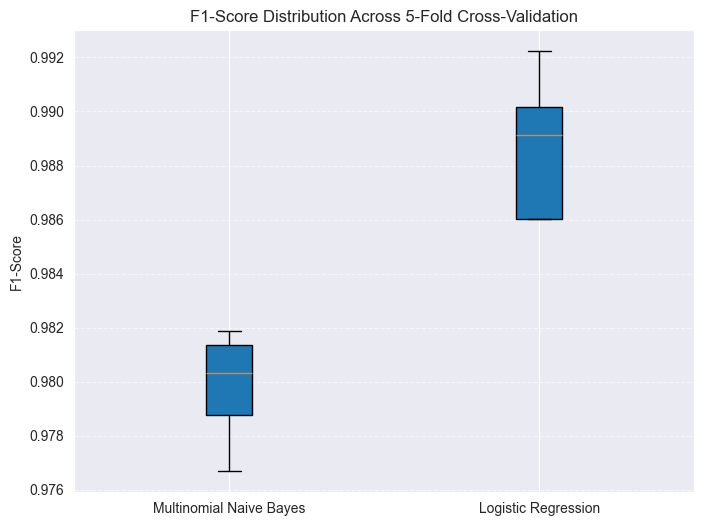

In [278]:
# Extract per-fold F1-scores from cross-validation outputs
nb_f1_scores = cv_results['Naive Bayes']['test_f1_macro']
lr_f1_scores = cv_results['Logistic Regression']['test_f1_macro']

plt.figure(figsize=(8, 6))
plt.boxplot([nb_f1_scores, lr_f1_scores], patch_artist=True)
plt.title('F1-Score Distribution Across 5-Fold Cross-Validation')
plt.ylabel('F1-Score')
plt.xticks([1, 2], ['Multinomial Naive Bayes', 'Logistic Regression'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()